In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import timedelta
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [50]:
df = pd.read_csv('F:\BaiduSyncdisk\Shengyou-Casual\S 数据分析\Session Analysis\session_240715_240724.csv')

In [51]:
#第一步 清洗数据#

# 删除 ActiveRegion 或 Country 字段等于 "China" 或 "Shanghai" 的数据
# 使用 ~ 符号代表逻辑非操作，& 代表逻辑与操作，| 代表逻辑或操作
mask = ~((df['ActiveRegion'] == 'China') | (df['ActiveRegion'] == 'Shanghai') |
          (df['Region'] == 'China') | (df['Region'] == 'Shanghai'))

# 使用布尔索引来筛选出不满足条件的行
df = df.loc[mask]

# 删除 AccCreateTime 和 CreateTime 至少一列有空值的行
df = df.dropna(subset=['AccCreateTime', 'CreateTime'])

# 将带有逗号分隔符的字段转化为纯数值字段
df['AccCreateTime'] = df['AccCreateTime'].str.replace(',', '').astype(int)
df['CreateTime'] = df['CreateTime'].str.replace(',', '').astype(int)
df['SessionTimeStart'] = df['SessionTimeStart'].str.replace(',', '').astype(int)
df['SessionTimeEnd'] = df['SessionTimeEnd'].str.replace(',', '').astype(int)

# 使用pd.to_datetime()将Unix时间戳转换为时间类型
df['AccCreateTime'] = pd.to_datetime(df['AccCreateTime'], unit='s')  # 秒为单位
df['CreateTime'] = pd.to_datetime(df['CreateTime'], unit='s')  # 秒为单位
df['SessionTimeStart'] = pd.to_datetime(df['SessionTimeStart'], unit='s')  # 秒为单位
df['SessionTimeEnd'] = pd.to_datetime(df['SessionTimeEnd'], unit='s')  # 秒为单位

# 删除无用列
df = df.drop('_id', axis=1)
df = df.drop('_index', axis=1)
df = df.drop('_score', axis=1)
df = df.drop('CreateDate', axis=1)

# 新增列Duration时长+LifeTime生命周期
df['Duration'] = (df['SessionTimeEnd'] - df['SessionTimeStart']).dt.total_seconds()/60
df['LifeTime'] = (df['CreateTime'] - df['AccCreateTime']).dt.days

# 转换CreateTime为日期格式（去除时间信息）
df['DateOnly'] = df['CreateTime'].dt.date

# 查看清洗后的数据
print(df.head())  # 打印前5行数据
print(df.info())  # 获取数据集的信息，包括每列的数据类型、非空值数量等

        AccCreateTime ActiveRegion             City          CreateTime  \
0 2024-07-23 14:02:10  Philippines           Manila 2024-07-24 05:56:00   
1 2024-07-17 02:23:04       Canada      Fredericton 2024-07-24 05:54:20   
2 2024-07-24 05:17:21  Philippines     Bacolod City 2024-07-24 05:53:44   
3 2024-07-24 05:49:52  Philippines  Cabanatuan City 2024-07-24 05:52:52   
4 2024-07-23 14:02:10  Philippines           Manila 2024-07-24 05:52:45   

   CurrentLevel                              DeviceID         Event  Platform  \
0            26  395c2c7a-de13-3beb-a7bc-030e9a433cb6  user_session         1   
1             5  aa5a07e0-627c-3914-ba08-bcfaf34565c4  user_session         1   
2            27  5245ebd5-4bcb-3a57-a167-2ac7e2554392  user_session         1   
3             2  a6922c75-3f56-310e-ad71-877680d9b10f  user_session         1   
4            25  395c2c7a-de13-3beb-a7bc-030e9a433cb6  user_session         1   

        Region ResVersion      SessionTimeEnd    SessionTimeSt

In [52]:
# 转化数据为每日的玩家总时长-总次数表，每日每玩家只有一条记录

# 按DeviceID和日期分组
grouped = df.groupby(['DeviceID', 'DateOnly'])

# 计算每天每人每个Session的平均Duration
average_duration_per_session = grouped['Duration'].mean().reset_index(name='AverageDurationPerSession')

# 计算每天每人平均的Session次数
average_session_count = grouped['Duration'].count().reset_index(name='SessionCount')

# 计算每天每人所有Session总Duration之和
total_duration_per_user = grouped['Duration'].sum().reset_index(name='TotalDuration')

# 合并结果
Daily = pd.merge(average_duration_per_session, average_session_count, on=['DeviceID', 'DateOnly'])
Daily = pd.merge(result, total_duration_per_user, on=['DeviceID', 'DateOnly']).reset_index()

Daily['DateOnly'] = pd.to_datetime(Daily['DateOnly'])

print(Daily.info())
print(Daily.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   level_0                    909 non-null    int64         
 1   index                      909 non-null    int64         
 2   DeviceID                   909 non-null    object        
 3   DateOnly                   909 non-null    datetime64[ns]
 4   AverageDurationPerSession  909 non-null    float64       
 5   SessionCount               909 non-null    int64         
 6   TotalDuration_x            909 non-null    float64       
 7   TotalDuration_y            909 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 56.9+ KB
None
   level_0  index                              DeviceID   DateOnly  \
0        0      0  000a3020-91a0-3c40-a4e9-a1c7b76c9a18 2024-07-15   
1        1      1  000a3020-91a0-3c40-a

In [53]:
# 总Matrix数据图 不分用户
# 计算每个日期的统计量
daily_stats = Daily.groupby('DateOnly').agg({
    'AverageDurationPerSession': ['mean', 'median'],
    'SessionCount': ['mean', 'median'],
    'TotalDuration_x': ['mean', 'median']
}).reset_index()

# 重新从多级索引设定字段
mean_avg_duration = daily_stats['AverageDurationPerSession']['mean']
median_avg_duration = daily_stats['AverageDurationPerSession']['median']
mean_session_count = daily_stats['SessionCount']['mean']
median_session_count = daily_stats['SessionCount']['median']
mean_total_duration = daily_stats['TotalDuration_x']['mean']
median_total_duration = daily_stats['TotalDuration_x']['median']

print(daily_stats.head())
# 检查聚合操作的结果
print(daily_stats.info())


    DateOnly AverageDurationPerSession            SessionCount         \
                                  mean     median         mean median   
0 2024-07-14                192.869815  71.219444     5.000000    5.0   
1 2024-07-15                675.375696  13.499074     6.468750    3.0   
2 2024-07-16                273.095723  10.372222     6.250000    3.0   
3 2024-07-17                681.734704  33.055417     8.277778    3.0   
4 2024-07-18                294.695826   7.029167     4.887931    2.0   

  TotalDuration_x              
             mean      median  
0      831.683333  427.316667  
1     1384.056250  111.791667  
2     1343.954167   30.125000  
3     1378.586111  292.066667  
4     1198.394109   14.058333  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   (DateOnly, 

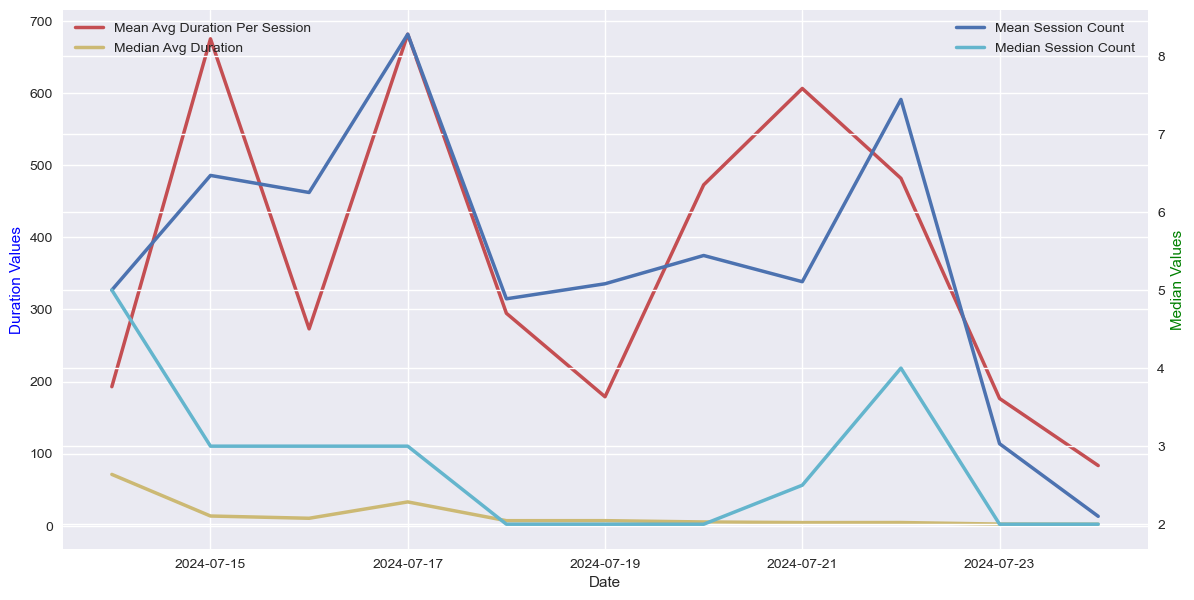

In [54]:
# 绘制每天在线时长相关的Session Matrix图表

# 设置绘图风格
plt.style.use('seaborn-v0_8')  # 使用内置的 seaborn-v0_8风格

# 新建一个图形和坐标轴
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制平均值的折线图
ax1.plot(daily_stats['DateOnly'], mean_avg_duration, label='Mean Avg Duration Per Session', color = '#C44E52', linewidth = 2.5)
ax1.plot(daily_stats['DateOnly'], median_avg_duration, label='Median Avg Duration', color = '#CCB974', linewidth = 2.5)

# 设置图例并激活第一个轴
ax1.legend(loc='upper left')
ax1.set_xlabel('Date')
ax1.set_ylabel('Duration Values', color='blue')

# 创建第二个轴对象，共享x轴
ax2 = ax1.twinx()

# 绘制中位数的折线图，使用第二个轴
ax2.plot(daily_stats['DateOnly'], mean_session_count, label='Mean Session Count', color = '#4C72B0', linewidth = 2.5)
ax2.plot(daily_stats['DateOnly'], median_session_count, label='Median Session Count', color = '#64B5CD', linewidth = 2.5)

# 设置第二个轴的图例
ax2.legend(loc='upper right')
ax2.set_ylabel('Median Values', color='green')

# 显示图表
plt.show()

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


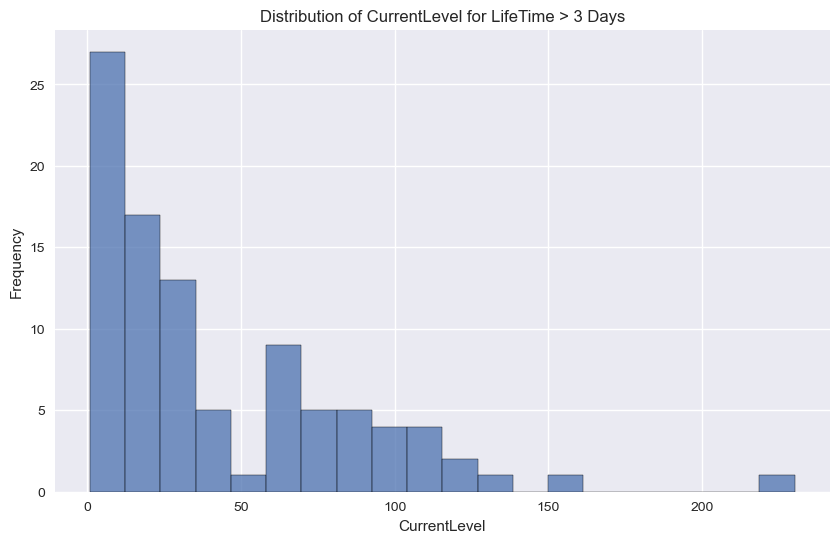

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 0 to 4262
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   AccCreateTime     608 non-null    datetime64[ns]
 1   ActiveRegion      608 non-null    object        
 2   City              608 non-null    object        
 3   CreateTime        608 non-null    datetime64[ns]
 4   CurrentLevel      608 non-null    int64         
 5   DeviceID          608 non-null    object        
 6   Event             608 non-null    object        
 7   Platform          608 non-null    int64         
 8   Region            608 non-null    object        
 9   ResVersion        608 non-null    object        
 10  SessionTimeEnd    608 non-null    datetime64[ns]
 11  SessionTimeStart  608 non-null    datetime64[ns]
 12  UserID            608 non-null    object        
 13  Version           608 non-null    object        
 14  Duration          608 non-null

In [55]:
# 关卡流失分布（3天流失）

# 步骤2：筛选每个 DeviceID 中 SessionTimeStart 最晚的记录
latest_sessions = df.groupby('DeviceID')['SessionTimeStart'].transform('max')
df_selected = df[df['SessionTimeStart'] == latest_sessions]

# 步骤3：筛选 LifeTime 大于3天的记录
df_filtered = df_selected[df_selected['LifeTime'] > 3]

# 步骤4：绘制 CurrentLevel 分布图
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['CurrentLevel'], bins=20, kde=False)
plt.title('Distribution of CurrentLevel for LifeTime > 3 Days')
plt.xlabel('CurrentLevel')
plt.ylabel('Frequency')
plt.show()

print(df_selected.info())

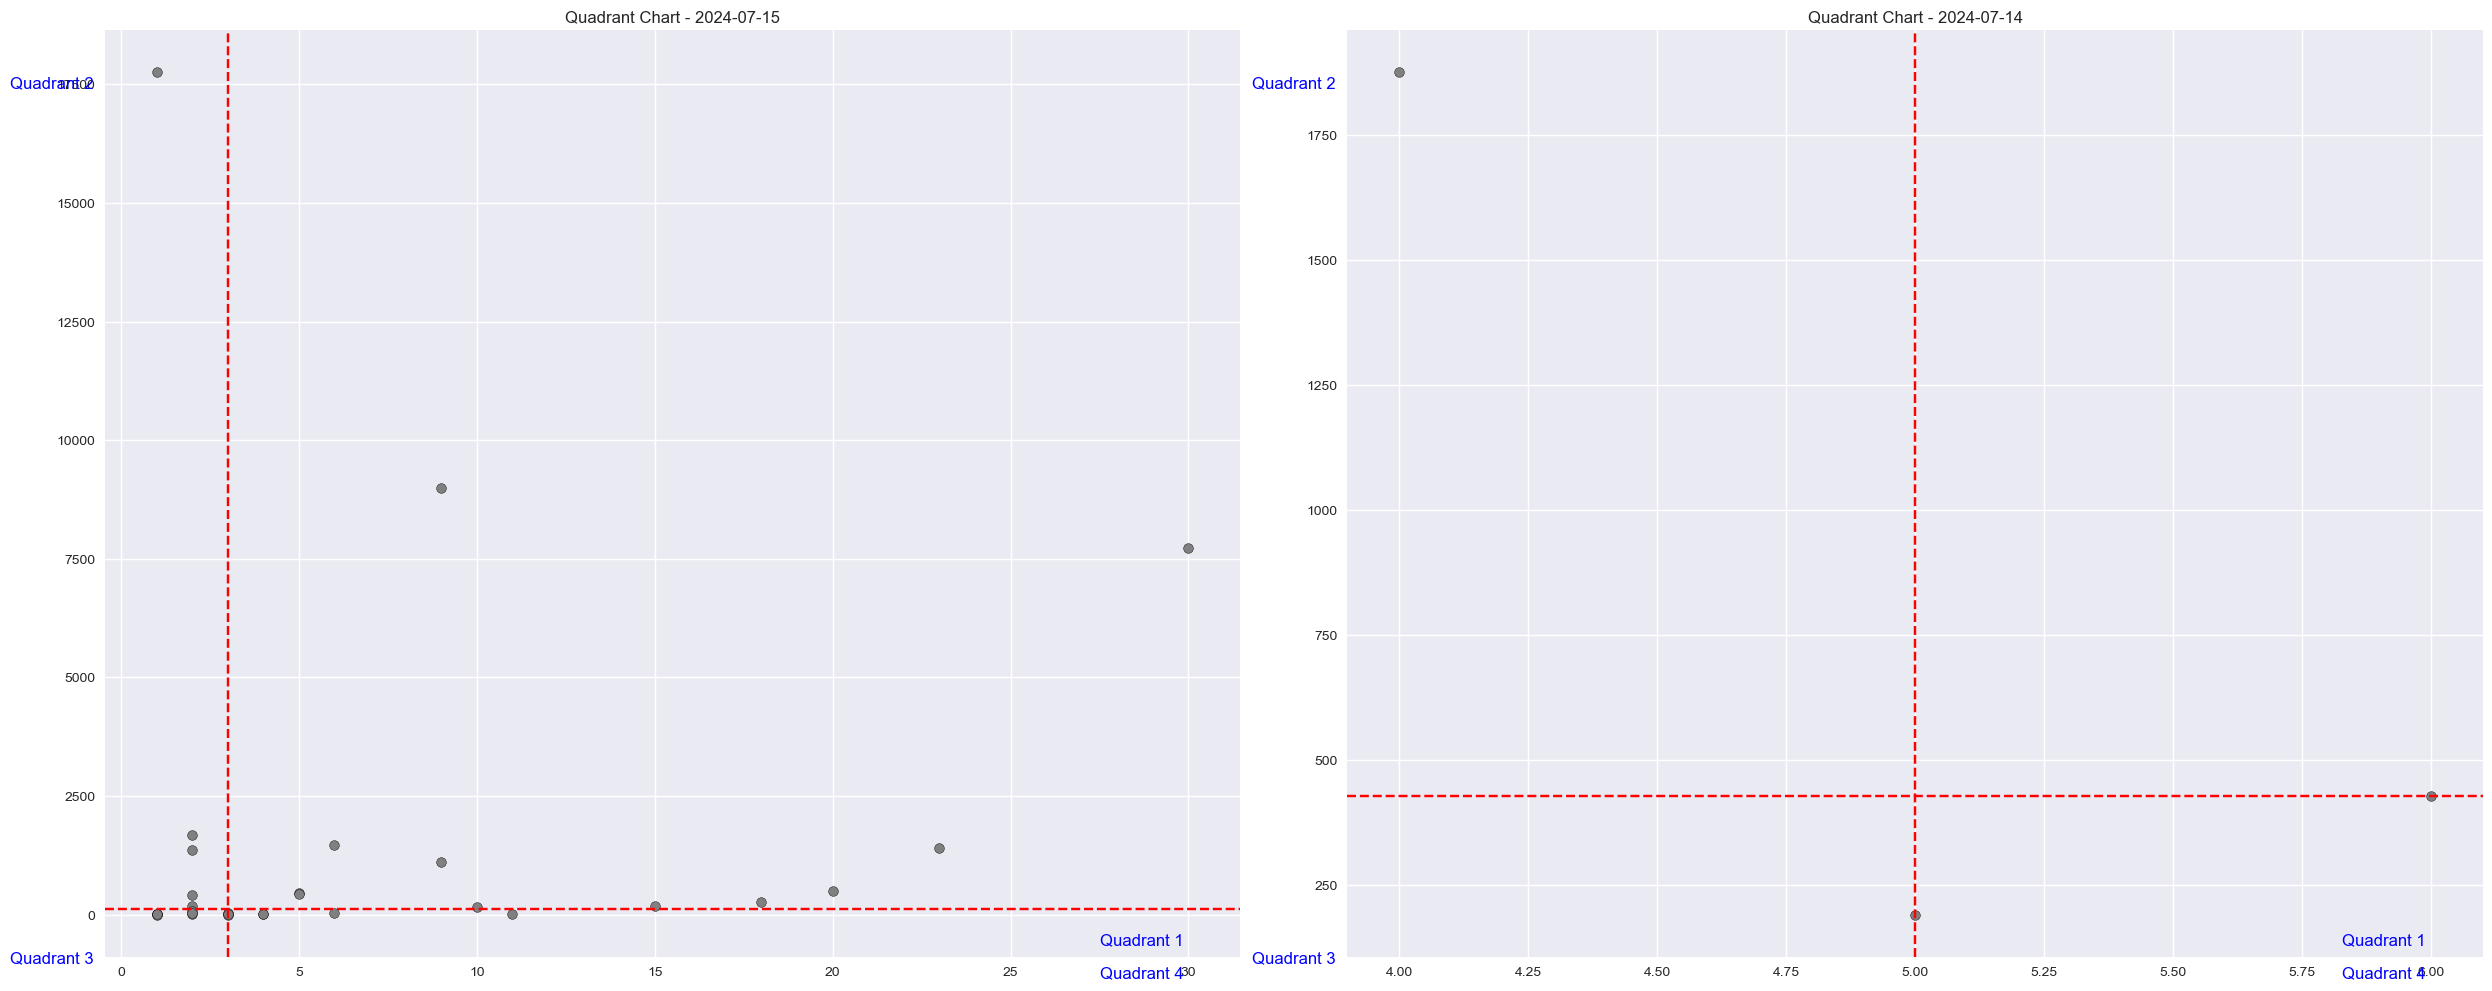

In [64]:
# 绘制四象限图-按日期分组的每天用户分布

start_date = datetime(2024, 7, 14)
end_date = datetime(2024, 7, 15)

dates = Daily[(Daily['DateOnly'] >= start_date) & (Daily['DateOnly'] <= end_date)]['DateOnly'].dt.date.unique()

# 为每个日期创建子图
fig, axes = plt.subplots(nrows=1, ncols=len(dates), figsize=(25, 10))

for i, date in enumerate(dates):
    # 筛选特定日期的数据
    date_df = Daily[Daily['DateOnly'].dt.date == date]
    
    # 计算中位数
    median_session_times = date_df['SessionCount'].median()
    median_duration = date_df['TotalDuration_x'].median()
    
    # 绘制四象限图
    axes[i].scatter(date_df['SessionCount'], date_df['TotalDuration_x'], c='grey', edgecolor='black')
    
    # 绘制象限线
    axes[i].axvline(x=median_session_times, color='r', linestyle='--')
    axes[i].axhline(y=median_duration, color='r', linestyle='--')
    
    # 标记象限
    axes[i].text(0.95, 0.01, 'Quadrant 1', verticalalignment='bottom', horizontalalignment='right',
                transform=axes[i].transAxes, color='blue', fontsize=12)
    axes[i].text(-0.01, 0.95, 'Quadrant 2', verticalalignment='top', horizontalalignment='right',
                transform=axes[i].transAxes, color='blue', fontsize=12)
    axes[i].text(-0.01, -0.01, 'Quadrant 3', verticalalignment='bottom', horizontalalignment='right',
                transform=axes[i].transAxes, color='blue', fontsize=12)
    axes[i].text(0.95, -0.01, 'Quadrant 4', verticalalignment='top', horizontalalignment='right',
                transform=axes[i].transAxes, color='blue', fontsize=12)
    
    # 设置标题
    axes[i].set_title(f'Quadrant Chart - {date}')

plt.tight_layout()
plt.show()